In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd

In [11]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [13]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [15]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

Last Date in data set: 2017-08-23. 1 year ago: 2016-08-23


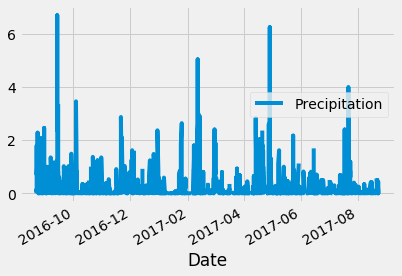

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdate= (session.query(Measurement.date)
    .order_by(Measurement.date.desc()).first())
lastdate

lastdate_str = str(lastdate)[2:-3]
year_ago = str(eval(lastdate_str[0:4])-1) + lastdate_str[4:]
print(f'Last Date in data set: {lastdate_str}. 1 year ago: {year_ago}')

# Perform a query to retrieve the data and precipitation scores
#precip_12 = (session.query(Measurement.date,
#    func.avg(Measurement.prcp))
#    .filter(Measurement.date > year_ago)
#    .group_by(Measurement.date)
#    .order_by(Measurement.date).all())
precip_12 = (session.query(Measurement.date,
     Measurement.prcp)
    .filter(Measurement.date >= year_ago)
    .order_by(Measurement.date).all())
    
#for row in precip_12:
 #   print(row)
    
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_12_df = pd.DataFrame(precip_12, columns = ['Date', 'Precipitation'])
precip_12_df['Date'] = pd.to_datetime(precip_12_df['Date'], format='%Y/%m/%d')

# Sort the dataframe by date
precip_12_date = precip_12_df.sort_values(by=['Date']).set_index('Date')
precip_12_date.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_12_date.plot()

# Exploratory Climate Analysis

![precipitation](Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_12_date.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = (session.query(Measurement.station, func.count(Measurement.station))
                  .group_by(Measurement.station)
                  .order_by(func.count(Measurement.id).desc())
                  .all())
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_station[0][0]
most_active_station
active_station_values = (session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs))
              .filter(Measurement.station == most_active_station))
active_station_values.all()

[(54.0, 85.0, 71.66378066378067)]

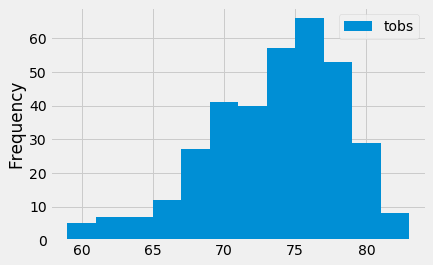

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
# plot the results as a histogram.

most_active_temp = (session.query(Measurement.tobs)
                    .filter(Measurement.date.between(year_ago, lastdate[0]))
                    .filter(Measurement.station == most_active_station)).all()

temps = [t[0] for t in most_active_temp]

temps
plt.hist(temps, bins = 12, label = 'tobs')
plt.legend()
plt.ylabel("Frequency")
plt.show()

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-07-07'
trip_end = '2017-07-14'
trip = (calc_temps(trip_start, trip_end)[0])
trip
min_trip = trip[0]
max_trip = trip[1]
avg_trip = trip[2]

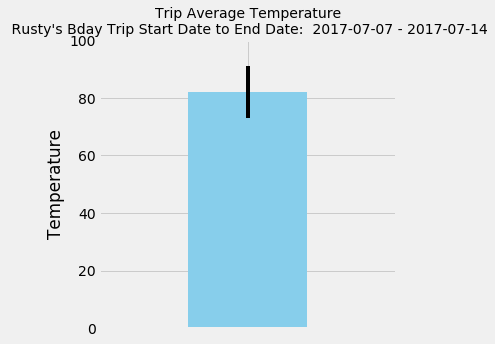

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(6,5))
plt.xlim(0, 2)
plt.ylim([0,100])
plt.bar(1, avg_trip, color = 'skyblue', yerr = max_trip-min_trip, tick_label="", align='center')
plt.title(f"Trip Average Temperature\n Rusty's Bday Trip Start Date to End Date:  {trip_start} - {trip_end}", fontsize=14)
plt.ylabel("Temperature")
plt.tight_layout()

plt.show()

In [31]:
# Display column names in measurement and stations tables. 
measurement_columns = [m.key for m in Measurement.__table__.columns]
station_columns = [s.key for s in Station.__table__.columns]

print(f'measurement: {measurement_columns} -- \nStation: {station_columns}')

measurement: ['id', 'station', 'date', 'prcp', 'tobs'] -- 
Station: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [32]:
# Calculate the rainfall per weather station for your trip dates 
#using the previous year's matching dates.
# Sort this in descending order by precipitation amount and 
#list the station, name, latitude, longitude, and elevation.

rainfall_station = (session.query(Station.station, 
     func.sum(Measurement.prcp),
     Station.name, Station.elevation, Station.latitude, Station.longitude)
    .filter(Measurement.station == Station.station)
    .filter(Measurement.date >= trip_start)
    .filter(Measurement.date <= trip_end)
    .group_by(Station.station)
    .order_by(func.sum(Measurement.prcp).desc())).all()

rainfall_df = (pd.DataFrame(rainfall_station, columns = 
    ['Station', 'Total Precip', 'Station Name', 'Elevation', 'Latitude', 'Longitute'])).set_index('Station')
rainfall_df.head()

,Total Precip,Station Name,Elevation,Latitude,Longitute
Station,,,,,
USC00516128,1.75,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250
USC00519281,1.13,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889
USC00513117,0.53,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150
USC00514830,0.38,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740
USC00519523,0.11,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching 
# a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_day_norm = daily_normals('07-07')
trip_day_norm

# Set the start and end date of the trip
trip_start = '2018-07-07'
trip_end = '2018-07-14'

# Use the start and end date to create a range of dates
trip_start_dt = dt.datetime.strptime(trip_start, '%Y-%m-%d').date()
trip_end_dt = dt.datetime.strptime(trip_end, '%Y-%m-%d').date()
trip_length = (trip_end_dt - trip_start_dt).days
trip_length

# Loop through the list of %m-%d strings and calculate the normals for each date
# Stip off the year and save a list of %m-%d strings

normals = []
trip_dates = []

for i in range(trip_length):
    trip_date = trip_start_dt + dt.timedelta(i)
    trip_dates.append(trip_date)
    day = trip_date.strftime('%m-%d')
    normals.append(daily_normals(day)[0])
    
normals

[(69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and 
# add the `trip_dates` range as the `date` index.

normals_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'], index = trip_dates)
normals_df.index.name = 'Date'
normals_df

,tmin,tavg,tmax
Date,,,
2018-07-07,69.0,74.910714,82.0
2018-07-08,69.0,76.083333,83.0
2018-07-09,68.0,76.192982,83.0
2018-07-10,68.0,75.620690,82.0
2018-07-11,70.0,75.789474,81.0
2018-07-12,67.0,75.964912,82.0
2018-07-13,69.0,76.189655,81.0


(50, 90)

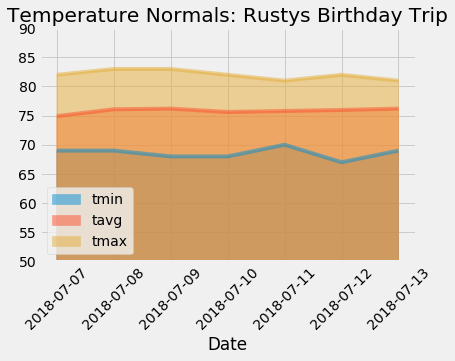

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
# Create data

normals_df.plot.area(stacked = False)
plt.xticks(rotation = 45)
plt.title('Temperature Normals: Rustys Birthday Trip')
plt.ylim(50,90)